<a href="https://colab.research.google.com/github/utility001/flower_classification/blob/train/flower_tl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
# !pip install --upgrade tf-keras
!pip install tensorflow==2.16.1
!pip install tensorflow_datasets
!pip install keras-tuner
!pip install scikit-learn==1.4.2
!pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 28.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 60.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 63.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 44.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 18.3 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.9.0
    Uninstalling h5py-3.9.0:
      Successfully uninstalled h5py-3.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
      Successfully uninstalled tensorboard-2.15.2
  Attempting uninstall: keras
    Fo

In [2]:
# import sklearn
import tensorflow as tf
import numpy as np
import sys
import os
import matplotlib.pyplot as plt

In [3]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [4]:
# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. Neural nets can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware "
              "accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

# EDA

The flowers here are not part of imagenet.

Train a pretrained model on the dataset. -- i.e transfer learning

If you want to build an image classifier but you do not have enough data to train it from scratch, then it is often a good idea to reuse the lower layers of a pretrained model, as we discussed in Chapter 11.

For example, let’s train a model to classify pictures of flowers, reusing a pretrained Xception model.

In [5]:
import tensorflow_datasets as tfds
# tfds?

In [6]:
dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [7]:
  print(info)

tfds.core.DatasetInfo(
    name='tf_flowers',
    full_name='tf_flowers/3.0.1',
    description="""
    A large set of images of flowers
    """,
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    data_dir='/root/tensorflow_datasets/tf_flowers/3.0.1.incomplete4KVZX9',
    file_format=tfrecord,
    download_size=218.21 MiB,
    dataset_size=221.83 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=5),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=3670, num_shards=2>,
    },
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/example_images/flower_photos.tgz" }""",
)


In [8]:
print(f"The keys in the dataframe is {info.supervised_keys}")
print(f"The splits in the dataset is {info.splits}")
print(f"The labels in the dataset is {info.features['label'].names}")

The keys in the dataframe is ('image', 'label')
The splits in the dataset is {'train': <SplitInfo num_examples=3670, num_shards=2>}
The labels in the dataset is ['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']


The dataset as only train set.

In [9]:
# Split the dataset
test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    "tf_flowers",
    shuffle_files=True,
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised=True)

In [10]:
train_set_raw

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [11]:
class_names = info.features["label"].names
class_names

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

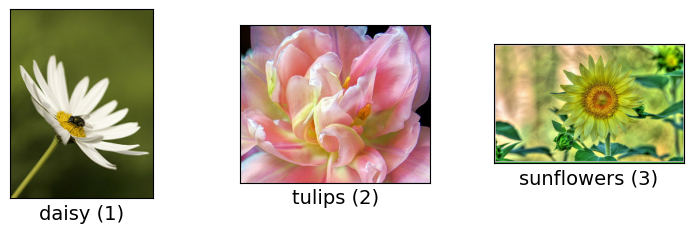

In [12]:
train_set_raw_3 = train_set_raw.take(3)
fig = tfds.show_examples(train_set_raw_3, info)

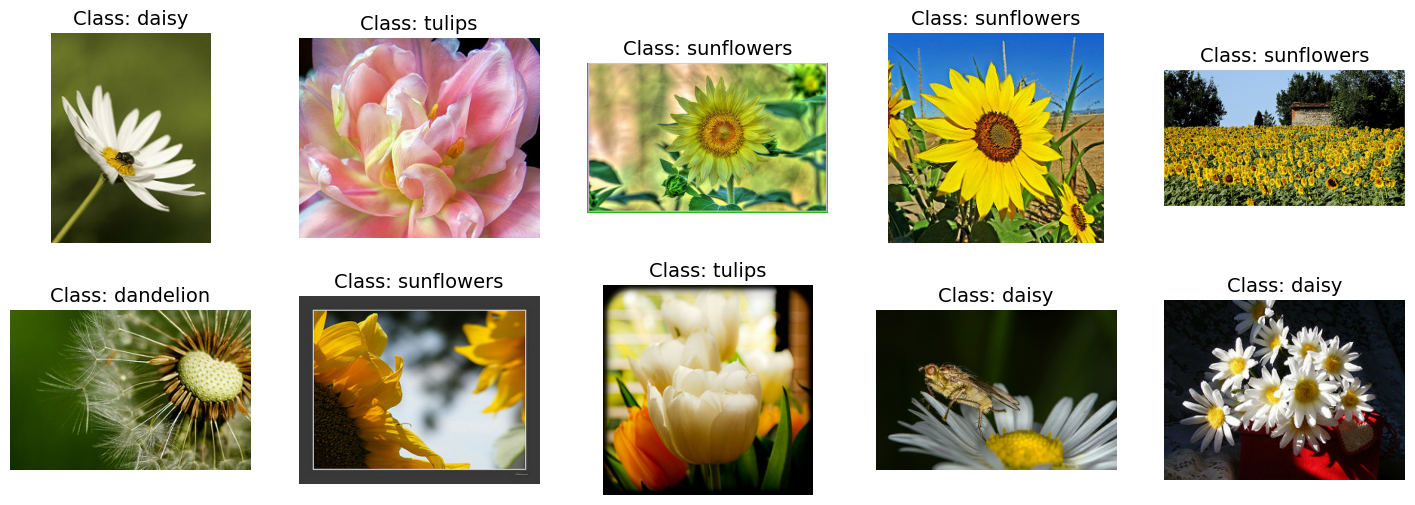

In [13]:
# Some images in the train set

plt.figure(figsize=(18, 6))
index=0
for image, label in train_set_raw.take(10):
  index += 1
  plt.subplot(2, 5, index)
  plt.imshow(image)
  plt.title(f"Class: {class_names[label]}")
  plt.axis("off")
plt.show()

+ We need to ensure that the images have the same size else batching will fail.  So we create a resizing layer.
+ Let's use Xception pretrained model
+ We'll also shuffle and prefetch the training set

In [14]:
mobilenet_model = tf.keras.applications.MobileNet(weights="imagenet", include_top=True)

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [15]:
mobilenet_model.summary()

Model: "mobilenet_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 112, 112, 32)        │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_bn (BatchNormalization)        │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_relu (ReLU)                    │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1 (DepthwiseConv2D)          │ (None, 112, 112, 32)        │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_bn (BatchNormalization)    │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_relu (ReLU)                │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1 (Conv2D)                   │ (None, 112, 112, 64)        │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_bn (BatchNormalization)    │ (None, 112, 112, 64)        │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_relu (ReLU)                │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pad_2 (ZeroPadding2D)           │ (None, 113, 113, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2 (DepthwiseConv2D)          │ (None, 56, 56, 64)          │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_bn (BatchNormalization)    │ (None, 56, 56, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_relu (ReLU)                │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2 (Conv2D)                   │ (None, 56, 56, 128)         │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3 (DepthwiseConv2D)          │ (None, 56, 56, 128)         │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_3 (Conv2D)                   │ (None, 56, 56, 128)         │          16,384 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 4,253,864 (16.23 MB)

 Trainable params: 4,231,976 (16.14 MB)

 Non-trainable params: 21,888 (85.50 KB)

In [16]:
# tf.keras.utils.plot_model(model, to_file="model_plots/cnn_fashion_mnist.png", show_shapes=True, dpi=60)

In [17]:
tf.keras.backend.clear_session()

batch_size = 32
preprocess = tf.keras.Sequential([
    tf.keras.layers.Resizing(height=224, width=224, crop_to_aspect_ratio=True),
    tf.keras.layers.Lambda(tf.keras.applications.mobilenet.preprocess_input)
])

In [18]:
train_set = train_set_raw.map(lambda X, y: (preprocess(X), y))
train_set = train_set.shuffle(1000, seed=42).batch(batch_size).prefetch(1)

In [19]:
# preprocess the validation set
valid_set = valid_set_raw.map(lambda X, y: (preprocess(X), y)).batch(batch_size)
test_set = test_set_raw.map(lambda X, y: (preprocess(X), y)).batch(batch_size)

Let's take a look again at the first 9 images from the validation set: they're all 224x224 now, with values ranging from -1 to 1:

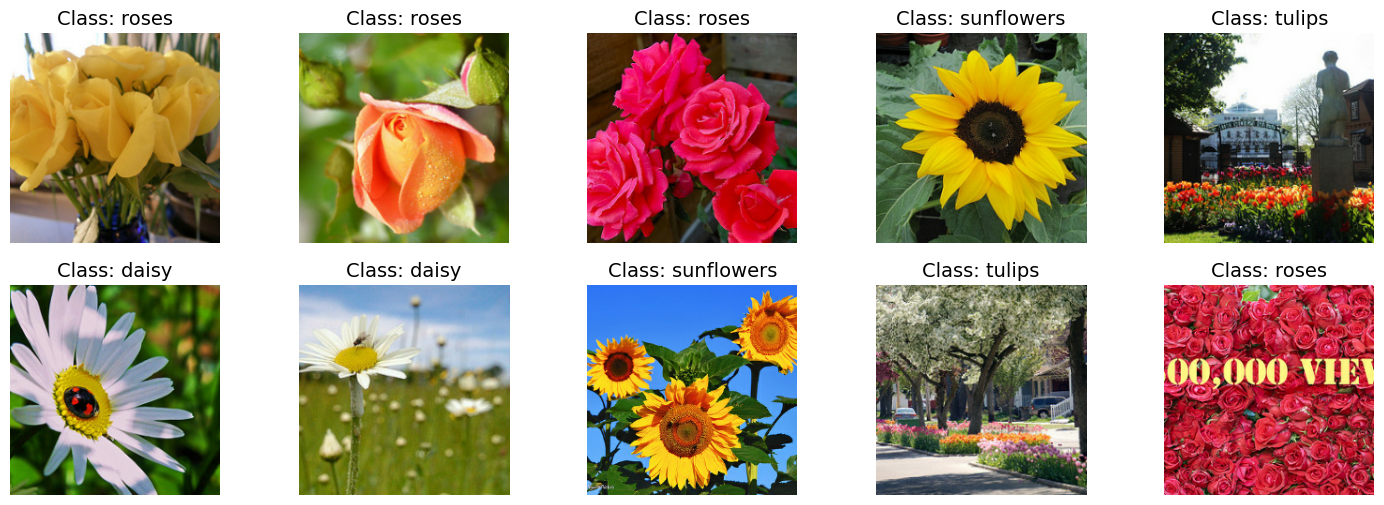

In [20]:
# View the images after resizing and batching

plt.figure(figsize=(18, 6))
index=0
for X_batch, y_batch in train_set.take(10):
  index += 1
  plt.subplot(2, 5, index)
  # print(f"max: {np.max(X_batch[index])}. min: {np.min(X_batch[index])}")
  plt.imshow((X_batch[index] / 2.) + 0.5)
  plt.title(f"Class: {class_names[y_batch[index]]}")
  plt.axis("off")

plt.show();

Each batch contains 32 images
Each image are 224, 224 pixels
The pixels values range from -1 to 1

The dataset is not very large. Let's perform data augmentation

In [21]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode="horizontal", seed=42),
    tf.keras.layers.RandomRotation(factor=0.05, seed=42),
    tf.keras.layers.RandomContrast(factor=0.2, seed=42)
])

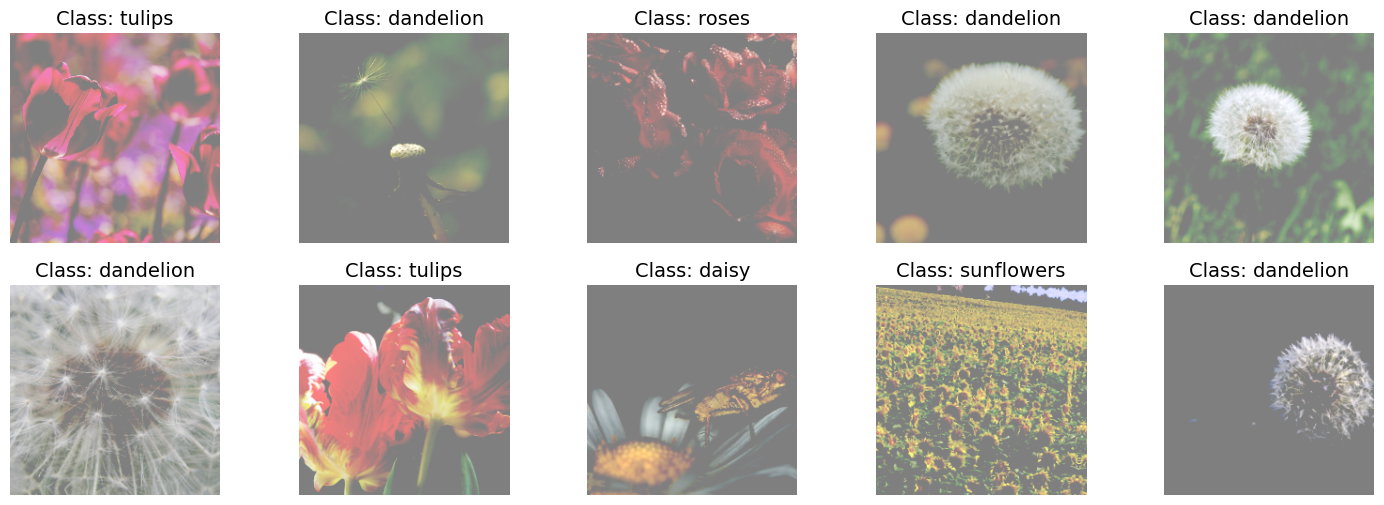

In [22]:
# Display some iamges after algmentation

plt.figure(figsize=(18, 6))
index=0
for X_batch, y_batch in train_set.take(10):
  X_batch_aug = data_augmentation(X_batch, training=True)
  index += 1
  plt.subplot(2, 5, index)
  # change the range to 0 - 1
  range = (X_batch_aug[index] / 2.) + 0.5
  # clip
  clipped = np.clip(range, 0, 1)
  plt.imshow(clipped)
  plt.title(f"Class: {class_names[y_batch[index]]}")
  plt.axis("off")

plt.show();

NOTE

Include the preprocessing or data augmentation layers inside the model, they will benefit from GPU acceleration during training.

# mobilenet_modeling

### Examine mobilenet and add the top layers to suit your task.

In [23]:
# # Examine mobilenet
# tf.keras.utils.plot_model(
#     mobilenet_model,
#     to_file="plot_model/original_architecture.png",
#     show_shapes=True,
#     show_layer_activations=True,
#     dpi=60)

In [24]:
# Load mobilenwt without its top layers
base_model = tf.keras.applications.MobileNet(weights="imagenet", input_shape=[224, 224, 3], include_top=False)

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [25]:
# Which layers were removed??
base_model.summary()

Model: "mobilenet_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 112, 112, 32)        │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_bn (BatchNormalization)        │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_relu (ReLU)                    │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1 (DepthwiseConv2D)          │ (None, 112, 112, 32)        │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_bn (BatchNormalization)    │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_relu (ReLU)                │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1 (Conv2D)                   │ (None, 112, 112, 64)        │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_bn (BatchNormalization)    │ (None, 112, 112, 64)        │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_relu (ReLU)                │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pad_2 (ZeroPadding2D)           │ (None, 113, 113, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2 (DepthwiseConv2D)          │ (None, 56, 56, 64)          │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_bn (BatchNormalization)    │ (None, 56, 56, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_relu (ReLU)                │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2 (Conv2D)                   │ (None, 56, 56, 128)         │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3 (DepthwiseConv2D)          │ (None, 56, 56, 128)         │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_3 (Conv2D)                   │ (None, 56, 56, 128)         │          16,384 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 3,228,864 (12.32 MB)

 Trainable params: 3,206,976 (12.23 MB)

 Non-trainable params: 21,888 (85.50 KB)

The last 5 layers in the full architecture starting from the global average pooling layer

In [26]:
n_classes = info.features["label"].num_classes
n_classes

5

In [27]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)


avg = tf.keras.layers.GlobalAveragePooling2D(keepdims=True)(base_model.output)
dropout = tf.keras.layers.Dropout(rate=0.001)(avg)
conv_preds = tf.keras.layers.Conv2D(filters=5, kernel_size=1, activation="linear")(dropout)
reshape_2 = tf.keras.layers.Reshape((n_classes,)) (conv_preds)
output = tf.keras.layers.Dense(n_classes, activation="softmax")(reshape_2)

model = tf.keras.Model(inputs=base_model.input, outputs=output)

In [28]:
# # Examine
# tf.keras.utils.plot_model(
#     model,
#     to_file="plot_model/my_architecture.png",
#     show_shapes=True,
#     show_layer_activations=True,
#     dpi=60)

In [29]:
# Freeze all of the weights of the pretrained layers
base_model.trainable = False

In [30]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 112, 112, 32)        │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_bn (BatchNormalization)        │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_relu (ReLU)                    │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1 (DepthwiseConv2D)          │ (None, 112, 112, 32)        │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_bn (BatchNormalization)    │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_relu (ReLU)                │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1 (Conv2D)                   │ (None, 112, 112, 64)        │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_bn (BatchNormalization)    │ (None, 112, 112, 64)        │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_relu (ReLU)                │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pad_2 (ZeroPadding2D)           │ (None, 113, 113, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2 (DepthwiseConv2D)          │ (None, 56, 56, 64)          │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_bn (BatchNormalization)    │ (None, 56, 56, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_relu (ReLU)                │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2 (Conv2D)                   │ (None, 56, 56, 128)         │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3 (DepthwiseConv2D)          │ (None, 56, 56, 128)         │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_3 (Conv2D)                   │ (None, 56, 56, 128)         │          16,384 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 3,234,019 (12.34 MB)

 Trainable params: 5,155 (20.14 KB)

 Non-trainable params: 3,228,864 (12.32 MB)

Task
+ Train teh model for a few epochs while keeping the base model weights fixed
+ This is in order to warm up the weights and biases in the top layers

Dilema: Do i need to perform hyperparameter tuning on the learning rate for this first training.
I think not.
I believe that the learning rate is not too important in the first training as it might have limited impact since the base layers are frozen and the top layers are too few compared to the rest of the model

Task:
+ Use a common learning rate.
Monitor the validation accuracy ----- Stalling model or overfitting. decrease learning rate. Underfitting. increase slightly

In [31]:
ecb = tf.keras.callbacks.EarlyStopping(patience=5)

In [32]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.1, beta_1=0.9,
                                     beta_2=0.999)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

In [33]:
history = model.fit(train_set, validation_data=valid_set, epochs=15, callbacks=[ecb])

Epoch 1/15
86/86 ━━━━━━━━━━━━━━━━━━━━ 25s 145ms/step - accuracy: 0.5792 - loss: 10.8114 - val_accuracy: 0.8185 - val_loss: 1.0222
Epoch 2/15
86/86 ━━━━━━━━━━━━━━━━━━━━ 26s 61ms/step - accuracy: 0.8899 - loss: 0.4199 - val_accuracy: 0.8131 - val_loss: 0.5790
Epoch 3/15
86/86 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - accuracy: 0.9225 - loss: 0.2470 - val_accuracy: 0.8494 - val_loss: 0.6695
Epoch 4/15
86/86 ━━━━━━━━━━━━━━━━━━━━ 8s 69ms/step - accuracy: 0.9416 - loss: 0.1744 - val_accuracy: 0.8276 - val_loss: 0.8342
Epoch 5/15
86/86 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - accuracy: 0.9481 - loss: 0.1462 - val_accuracy: 0.8403 - val_loss: 1.0739
Epoch 6/15
86/86 ━━━━━━━━━━━━━━━━━━━━ 11s 62ms/step - accuracy: 0.9518 - loss: 0.1888 - val_accuracy: 0.8457 - val_loss: 1.1096
Epoch 7/15
86/86 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - accuracy: 0.9286 - loss: 0.3481 - val_accuracy: 0.8584 - val_loss: 1.0962


Now the top layers are not too bad.  
+ Let's make the top part of the base mode trainable again.
+ Tune the learning rate
+ Utilize learning rate scheduling

In [34]:
len(model.layers)

91

In [35]:
for layer in base_model.layers[70:]:
    layer.trainable = True

In [36]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 112, 112, 32)        │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_bn (BatchNormalization)        │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_relu (ReLU)                    │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1 (DepthwiseConv2D)          │ (None, 112, 112, 32)        │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_bn (BatchNormalization)    │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_relu (ReLU)                │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1 (Conv2D)                   │ (None, 112, 112, 64)        │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_bn (BatchNormalization)    │ (None, 112, 112, 64)        │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_relu (ReLU)                │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pad_2 (ZeroPadding2D)           │ (None, 113, 113, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2 (DepthwiseConv2D)          │ (None, 56, 56, 64)          │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_bn (BatchNormalization)    │ (None, 56, 56, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_relu (ReLU)                │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2 (Conv2D)                   │ (None, 56, 56, 128)         │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3 (DepthwiseConv2D)          │ (None, 56, 56, 128)         │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_3 (Conv2D)                   │ (None, 56, 56, 128)         │          16,384 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 3,244,331 (12.38 MB)

 Trainable params: 1,862,179 (7.10 MB)

 Non-trainable params: 1,371,840 (5.23 MB)

 Optimizer params: 10,312 (40.29 KB)

#### Hyperparameter tuning

Tune learning schedule hyperparameters

In [37]:
import keras_tuner as kt

In [41]:
def build_model(hp):
    dr = hp.Float('decay_rate', min_value=0.2, max_value=2, sampling='log')
    ds = hp.Int('decay_steps', min_value=50, max_value=300)
    ilr = hp.Float('init_l_r', min_value=0.001, max_value=0.01, sampling='log')

    lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
        initial_learning_rate=ilr,
        decay_steps=ds,
        decay_rate=dr,
        staircase=False
    )

    optimizer = tf.keras.optimizers.Adam(
        learning_rate=lr_schedule,
        beta_1=0.9, beta_2=0.999
    )

    model_clone = tf.keras.models.clone_model(model)
    model_clone.set_weights(model.get_weights())

    model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=optimizer, metrics=["accuracy"])

    return model

In [42]:
random_search_tuner = kt.RandomSearch(
    build_model, objective="val_accuracy", max_trials=10, overwrite=True,
    directory="kt_parameter_tuning", project_name="random_search", seed=42)

In [43]:
random_search_tuner.search(train_set, epochs=10,
                           validation_data=valid_set)

Trial 1 Complete [00h 01m 49s]
val_accuracy: 0.9147005677223206

Best val_accuracy So Far: 0.9147005677223206
Total elapsed time: 00h 01m 49s

Search: Running Trial #2

Value             |Best Value So Far |Hyperparameter
0.37403           |0.87188           |decay_rate
272               |59                |decay_steps
0.0022483         |0.0025617         |init_l_r

Epoch 1/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 21s 117ms/step - accuracy: 0.9026 - loss: 0.7537 - val_accuracy: 0.6806 - val_loss: 8.1738
Epoch 2/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 13s 65ms/step - accuracy: 0.9414 - loss: 0.2601 - val_accuracy: 0.8530 - val_loss: 1.4130
Epoch 3/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 12s 93ms/step - accuracy: 0.9737 - loss: 0.0944 - val_accuracy: 0.8512 - val_loss: 0.6265
Epoch 4/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 8s 71ms/step - accuracy: 0.9878 - loss: 0.0469 - val_accuracy: 0.8966 - val_loss: 0.3891
Epoch 5/10
53/86 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.9957 - loss: 0.0190

KeyboardInterrupt: 

In [46]:
best_trials = random_search_tuner.oracle.get_best_trials(num_trials=5)

In [47]:
best_trials[0].summary()

Trial 02 summary
Hyperparameters:
decay_rate: 0.7066230891981429
decay_steps: 63
init_l_r: 0.0031443911752710788
Score: 0.9128856658935547


In [49]:
best_trials[1].summary()

Trial 07 summary
Hyperparameters:
decay_rate: 0.5574028960646222
decay_steps: 145
init_l_r: 0.002598627315978154
Score: 0.9092559218406677


In [ ]:
best_trials[1].summary()

#### Continue training

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005, beta_1=0.9,
                                     beta_2=0.999)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

In [ ]:
history = model.fit(train_set, validation_data=valid_set, epochs=10)

Epoch 1/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 20s 98ms/step - accuracy: 0.6847 - loss: 0.9179 - val_accuracy: 0.5009 - val_loss: 1.4361
Epoch 2/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 15s 94ms/step - accuracy: 0.7750 - loss: 0.7360 - val_accuracy: 0.7405 - val_loss: 0.9273
Epoch 3/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - accuracy: 0.8096 - loss: 0.6096 - val_accuracy: 0.7296 - val_loss: 1.0920
Epoch 4/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - accuracy: 0.8549 - loss: 0.4510 - val_accuracy: 0.8113 - val_loss: 0.7731
Epoch 5/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 11s 63ms/step - accuracy: 0.9556 - loss: 0.1860 - val_accuracy: 0.7623 - val_loss: 1.1738
Epoch 6/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 8s 73ms/step - accuracy: 0.9756 - loss: 0.0859 - val_accuracy: 0.8911 - val_loss: 0.4635
Epoch 7/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - accuracy: 0.9682 - loss: 0.0941 - val_accuracy: 0.8893 - val_loss: 0.4465
Epoch 8/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.9840 - loss: 0.0476 - val_accuracy: 0.871

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(patience=5)

In [ ]:
for layer in model.layers[40:]:
    layer.trainable = True

In [ ]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 112, 112, 32)        │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_bn (BatchNormalization)        │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_relu (ReLU)                    │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1 (DepthwiseConv2D)          │ (None, 112, 112, 32)        │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_bn (BatchNormalization)    │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_relu (ReLU)                │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1 (Conv2D)                   │ (None, 112, 112, 64)        │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_bn (BatchNormalization)    │ (None, 112, 112, 64)        │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_relu (ReLU)                │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pad_2 (ZeroPadding2D)           │ (None, 113, 113, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2 (DepthwiseConv2D)          │ (None, 56, 56, 64)          │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_bn (BatchNormalization)    │ (None, 56, 56, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_relu (ReLU)                │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2 (Conv2D)                   │ (None, 56, 56, 128)         │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3 (DepthwiseConv2D)          │ (None, 56, 56, 128)         │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_3 (Conv2D)                   │ (None, 56, 56, 128)         │          16,384 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 6,958,379 (26.54 MB)

 Trainable params: 3,075,107 (11.73 MB)

 Non-trainable params: 158,912 (620.75 KB)

 Optimizer params: 3,724,360 (14.21 MB)

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001, beta_1=0.9,
                                     beta_2=0.999)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

In [ ]:
history = model.fit(train_set, validation_data=valid_set, epochs=50, callbacks=[early_stop])

Epoch 1/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 26s 105ms/step - accuracy: 0.9905 - loss: 0.0326 - val_accuracy: 0.8929 - val_loss: 0.3638
Epoch 2/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 9s 75ms/step - accuracy: 0.9942 - loss: 0.0263 - val_accuracy: 0.8947 - val_loss: 0.3196
Epoch 3/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 11s 88ms/step - accuracy: 0.9949 - loss: 0.0203 - val_accuracy: 0.9020 - val_loss: 0.3021
Epoch 4/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 9s 82ms/step - accuracy: 0.9954 - loss: 0.0235 - val_accuracy: 0.9020 - val_loss: 0.3034
Epoch 5/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 10s 82ms/step - accuracy: 0.9979 - loss: 0.0145 - val_accuracy: 0.9038 - val_loss: 0.3014
Epoch 6/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 10s 74ms/step - accuracy: 0.9973 - loss: 0.0148 - val_accuracy: 0.9056 - val_loss: 0.3029
Epoch 7/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 9s 85ms/step - accuracy: 0.9957 - loss: 0.0207 - val_accuracy: 0.9093 - val_loss: 0.2991
Epoch 8/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - accuracy: 0.9971 - loss: 0.0152 - val_accuracy: 0.905

KeyboardInterrupt: 

In [ ]:
import keras_tuner as kt

def build_model(hp):
    n_hidden = hp.Int("n_hidden", min_value=2, max_value=5)

    learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=1e-2,
                             sampling="log")

    initializer = hp.Choice("kernel_initializer", values=["he_normal", "he_uniform"])
    if initializer == 'he_normal':
        initializer = tf.keras.initializers.he_normal()
    elif initializer == 'he_normal':
        initializer = tf.keras.initializers.he_uniform()

    activation = hp.Choice('activation', values=['relu', 'leaky_relu', 'swish'])
    if activation == 'relu':
        activation = tf.keras.activations.relu
    elif activation == 'leaky_relu':
        activation = tf.keras.activations.leaky_relu
    elif activation == 'swish':
        activation = tf.keras.activations.swish

    optimizer = hp.Choice("optimizer", values=["sgd", "adam"])
    if optimizer == "sgd":
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    else:
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer(shape=input_shape))
    model.add(tf.keras.layers.Flatten())
    for _ in range(n_hidden):
        model.add(tf.keras.layers.Dense(
            200, #200 neurons fixed
            activation=activation,
            kernel_initializer=initializer
        ))
    model.add(tf.keras.layers.Dense(10, activation="softmax"))
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
                  metrics=["accuracy"])
    return model




random_search_tuner = kt.RandomSearch(
    build_model, objective="val_accuracy", max_trials=20, overwrite=False,
    directory="my_fashion_mnist", project_name="random_search", seed=42)


random_search_tuner.search(X_train, y_train, epochs=10,
                           validation_data=(X_val, y_val))


best_trials = random_search_tuner.oracle.get_best_trials(num_trials=5)

best_trials[0].summary()

best_trials[1].summary()

This model should reach around 92% accuracy on the test set, in just a few
minutes of training (with a GPU).

If you tune the hyperparameters, lower the learning rate, and train for quite a bit longer, you should be able to reach 95% to 97%.

With that, you can start training amazing image classifiers on your own images and classes!

In [ ]:
model.save("adam_flower_classifier.keras")

# Evaluation

In [ ]:
saved_model = tf.keras.models.load_model("saved_model/adam_flower_classifier.keras")

In [ ]:
batch_size = 10

In [ ]:
loss, acc = saved_model.evaluate(valid_set)

I0000 00:00:1715456611.117863  136408 service.cc:145] XLA service 0x7fbf5007be40 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1715456611.117912  136408 service.cc:153]   StreamExecutor device (0): Host, Default Version
2024-05-11 20:43:31.693751: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1715456615.168700  136408 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


56/56 ━━━━━━━━━━━━━━━━━━━━ 198s 3s/step - accuracy: 0.8999 - loss: 0.2853


In [ ]:
true_labels = []
predicted_labels = []

# Get the  predictions and their original labels
for image, label in valid_set:
    # Get pred probas
    pred= saved_model.predict(image)
    # convert them to actual classes
    predicted_labels.extend(pred.argmax(axis=1))
    # get the true label
    true_labels.extend(label)

56/56 ━━━━━━━━━━━━━━━━━━━━ 191s 3s/step


In [ ]:
np_true_labels = np.array(true_labels)
np_true_labels[:10]

array([0, 0, 0, 0, 0, 4, 0, 2, 3, 1])

In [ ]:
np_predicted_labels = np.array(predicted_labels)
np_predicted_labels[:10]

array([0, 2, 0, 0, 0, 4, 4, 2, 3, 1])

In [ ]:
misclassified = np.flatnonzero(np_true_labels != np_predicted_labels)
# how many
print(len(misclassified))
# View 10
misclassified[:10]

48


array([ 1,  6, 23, 26, 28, 47, 51, 63, 84, 88])

In [ ]:
class_names

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

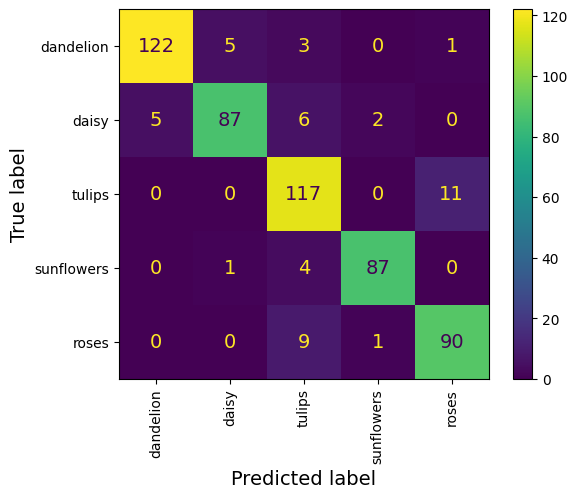

In [ ]:
ConfusionMatrixDisplay.from_predictions(
    y_true = true_labels,
    y_pred = predicted_labels,
    display_labels=class_names,
    xticks_rotation="vertical"
);

# Predictions with Gradio

In [ ]:
def image_pred(image, crop_to_aspect_ratio=True):
    # convert the image to a numpy array
    image = np.array(image)

    # Add an axis. To represent batch size. Models are trained with an extra axis at the front to represent batch size
    image = image[np.newaxis, ...]

    # resize the image
    resize = tf.keras.layers.Resizing(
        height=224,
        width=224,
        crop_to_aspect_ratio=crop_to_aspect_ratio
    )
    res_img = resize(image)

    # preprocess the image
    prep_img = tf.keras.applications.mobilenet.preprocess_input(res_img)

    # pred_probas
    pred_probas = saved_model.predict(prep_img)
    # Get the value of the max predicion probability
    max_pred_proba = np.max(pred_probas)
    # get the ineex of the max prediction probability
    pred = np.argmax(pred_probas, axis=1)
    # label
    label = class_names[pred[0]]

    # Convert the transformed image to an array
    res_array = np.array(res_img)
    # remove the first axis that was added above
    squeeze = np.squeeze(res_array, axis=0)
    # divide by max value
    plot_image = squeeze/250
    # clip
    clip = np.clip(plot_image, 0, 1)

    return clip, f"{label} {max_pred_proba}%"

In [ ]:
# from PIL import Image

# image_path = "sample_image/ss.jpg"
# image = Image.open(image_path)

# # Convert  to np array
# image_array = np.array(image)

# image_array.shape

In [ ]:
# t, u = image_pred(image_array)
# t

In [ ]:
import gradio as gr

In [ ]:
# Create the Gradio interface
interface = gr.Interface(
    fn=image_pred,
    inputs=[
        gr.Image(value="Image", type="numpy"),
        gr.Checkbox(label="Crop to aspect ratio")
    ],
    outputs=[
        gr.Image(value="Image", type="numpy", height=250, width=250),
        gr.Text(label="Prediction"),
    ],
    title="MobileNet 50 pretrained model. Trained on Flower dataset",
    description="""
    Predict 5 species of flower
    """
)

# Run the Gradio interface
interface.launch()

Running on local URL:  http://127.0.0.1:7862

To create a public link, set `share=True` in `launch()`.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step
